In [1]:
import tensorflow as tf
import keras
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix

C:\Users\helen\anaconda3\envs\fakenews\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
print  ("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


In [3]:
print(tf.config.list_physical_devices)

<function list_physical_devices at 0x00000217C71E47B8>


In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13800032239222285921
]


In [5]:
test = pd.read_csv("C:/Users/helen/Fake News/recovery-news-data.csv")
test.columns
test.head()

,Unnamed: 0,news_id,url,publisher,publish_date,author,title,image,body_text,political_bias,country,reliability
0,0,0,https://www.nytimes.com/article/what-is-corona...,The New York Times,2020-01-21,"['Knvul Sheikh', 'Roni Caryn Rabin']",The Coronavirus: What Scientists Have Learned ...,https://static01.nyt.com/images/2020/03/12/sci...,\nA novel respiratory virus that originated in...,Left,USA,1
1,1,1,https://www.npr.org/2020/01/22/798392172/chine...,National Public Radio (NPR),2020-01-22,['Emily Feng'],Chinese Health Officials: More Die From Newly ...,https://media.npr.org/include/images/facebook-...,Chinese Health Officials: More Die From Newly ...,Center,USA,1
2,2,2,https://www.theverge.com/2020/1/23/21078457/co...,The Verge,2020-01-23,['Nicole Wetsman'],Everything you need to know about the coronavirus,https://cdn.vox-cdn.com/thumbor/a9_Oz7cvSBKyal...,Public health experts around the globe are scr...,Left-center,USA,1
3,3,3,https://www.worldhealth.net/news/novel-coronav...,WorldHealth.Net,2020-01-24,[],Novel Coronavirus Cases Confirmed To Be Spreading,https://www.worldhealth.net/media/original_ima...,The first two coronavirus cases in Europe have...,NaN,USA,0
4,4,4,https://www.theverge.com/2020/1/24/21080845/co...,The Verge,2020-01-24,"['Nicole Wetsman', 'Zoe Schiffer', 'Jay Peters...",Coronavirus disrupts the world: updates on the...,https://cdn.vox-cdn.com/thumbor/t2gt1SmEni4Mcr...,"A new coronavirus appeared in Wuhan, China, at...",Left-center,USA,1


In [6]:
test['reliability'].value_counts()

1    1364
0     665
Name: reliability, dtype: int64

<AxesSubplot:xlabel='reliability', ylabel='count'>

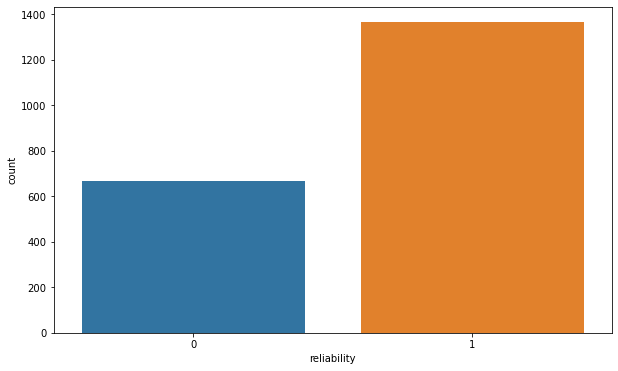

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(x='reliability', data=test)
# 1 = reliable
# 0 = unreliable

In [8]:
test['body_text'] = test['body_text'].apply(lambda x: str(x).lower())

In [9]:
test = test[['body_text', 'reliability']]

In [10]:
test['reliability'] = test['reliability'].astype(float)

In [11]:
import spacy
spacy.load('en_core_web_sm')

In [12]:
#!pip install spacy== 3.0.0
#!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\helen\appdata\local\temp\pip-req-build-c99g23lo
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7692 sha256=74c40f057e68e77551e0ca90d835e9c15f6d954775af66a6fd2010787bfa6fe8
  Stored in directory: C:\Users\helen\AppData\Local\Temp\pip-ephem-wheel-cache-wuipnlk2\wheels\cd\26\af\103cfac199bd773bfc95ed85a52fe9095e4d902ed9ac3b0c97


  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\helen\AppData\Local\Temp\pip-req-build-c99g23lo'


Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [13]:
import preprocess_kgptalkie as ps

In [14]:
test['body_text'] = test['body_text'].apply(lambda x: ps.remove_special_chars(x))

In [15]:
test

,body_text,reliability
0,a novel respiratory virus that originated in w...,1.0
1,chinese health officials more die from newly i...,1.0
2,public health experts around the globe are scr...,1.0
3,the first two coronavirus cases in europe have...,0.0
4,a new coronavirus appeared in wuhan china at t...,1.0
...,...,...
2024,robert gauthierlos angeles timestns people wal...,0.0
2025,michael moore for decades on the political fro...,0.0
2026,heather khalifathe philadelphia inquirertns vo...,0.0
2027,nearly half of the twitter accounts sharing in...,0.0


In [16]:
x = [d.split() for d in test['body_text'].tolist()]
y = test['reliability'].values

In [17]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [18]:
print(len(x))

2029


In [19]:
DIM = 400
w2v_model = gensim.models.Word2Vec(sentences=x, vector_size=DIM, window=10, min_count=1)

In [20]:
len(w2v_model.wv.key_to_index)

84171

In [21]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x)

In [22]:
x = tokenizer.texts_to_sequences(x)

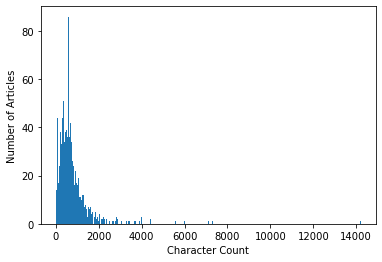

In [23]:
plt.hist([len(a) for a in x], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
plt.show()

In [24]:
nos = np.array([len(a) for a in x])
len(nos[nos>1000])

490

In [25]:
maxlen = 100
x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=maxlen)

In [26]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [27]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items():
        try:
            weight_matrix[i] = model.wv[word]
        except:
            print("whatever")
        
    return weight_matrix

In [28]:
embedding_vectors = get_weight_matrix(w2v_model)

In [29]:
embedding_vectors.shape

(84172, 400)

In [30]:
maxlen

100

In [31]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable = False))
model.add(Conv1D(128, 5, activation="relu", input_dim=100))
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid")) 
model.add(LSTM(32))
model.add(Dense(2, activation = 'sigmoid')) 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
    optimizer = "Adam",               
              metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 400)          33668800  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           256128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 33,945,602
Trainable params: 276,802
Non-trainable params: 33,668,800
_________________________________________________________________


In [32]:
from platform import python_version
python_version()
import tensorflow as tf
print(tf.__version__)

2.6.2


In [33]:
CNNRNNX_train, CNNRNNX_test, CNNRNNy_train, CNNRNNy_test = train_test_split(x, y, test_size=0.2)

In [34]:
# [1, 0] is false [0, 1] is true
CNNRNNy_train = [[1,0] if x==0.0 else [0,1] if x==1.0 else x for x in CNNRNNy_train]
CNNRNNy_test = [[1,0] if x==0.0 else [0,1] if x==1.0 else x for x in CNNRNNy_test]

In [35]:
CNNRNNy_train = np.array(CNNRNNy_train)
CNNRNNy_test = np.array(CNNRNNy_test)

In [36]:
model.fit(CNNRNNX_train, CNNRNNy_train, epochs=1, batch_size=64)

26/26 [==============================] - 9s 103ms/step - loss: 0.5955 - accuracy: 0.7024 - recall: 0.7153 - precision: 0.6866 - true_negatives: 1093.0000 - true_positives: 1161.0000 - false_positives: 530.0000 - false_negatives: 462.0000


In [37]:
model.evaluate(CNNRNNX_test, CNNRNNy_test)

13/13 [==============================] - 3s 27ms/step - loss: 0.5595 - accuracy: 0.7217 - recall: 0.7414 - precision: 0.7167 - true_negatives: 287.0000 - true_positives: 301.0000 - false_positives: 119.0000 - false_negatives: 105.0000


[0.5595079064369202,
 0.7216748595237732,
 0.7413793206214905,
 0.7166666388511658,
 287.0,
 301.0,
 119.0,
 105.0]

In [38]:
!pip install whois
!pip install pyquery
!pip install tqdm
!pip install interruptingcow
!pip install requests

In [39]:
import requests
from interruptingcow import timeout
import whois
from datetime import datetime, timezone
import math
import pandas as pd
import numpy as np
from pyquery import PyQuery
from requests import get
import tensorflow as tf
import keras
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [40]:
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now().replace(tzinfo=None)

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    ## URL string Features
    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def ip(self):
        string = self.url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1 
        else:
            return 0

    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        return len(self.url)

    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date'].replace(tzinfo=None)
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'].replace(tzinfo=None) - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
     ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        v = self.specialCharacters()
        if self.pq is not None and v!=0:
            sscr = self.scriptLength()/v
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            sbr = self.scriptLength()/v
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            bscr = self.specialCharacters()/v
        else:
            bscr = 0
        return bscr

    def urlIsLive(self):
        return self.response == 200

    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        data['num_%20'] = self.url.count("%20")
        data['num_@'] = self.url.count("@")
        data['has_ip'] = self.ip()
    
        return data

In [41]:
data = pd.read_csv('C:/Users/helen/Fake News/recovery-news-data.csv')
data.head(5)

,Unnamed: 0,news_id,url,publisher,publish_date,author,title,image,body_text,political_bias,country,reliability
0,0,0,https://www.nytimes.com/article/what-is-corona...,The New York Times,2020-01-21,"['Knvul Sheikh', 'Roni Caryn Rabin']",The Coronavirus: What Scientists Have Learned ...,https://static01.nyt.com/images/2020/03/12/sci...,\nA novel respiratory virus that originated in...,Left,USA,1
1,1,1,https://www.npr.org/2020/01/22/798392172/chine...,National Public Radio (NPR),2020-01-22,['Emily Feng'],Chinese Health Officials: More Die From Newly ...,https://media.npr.org/include/images/facebook-...,Chinese Health Officials: More Die From Newly ...,Center,USA,1
2,2,2,https://www.theverge.com/2020/1/23/21078457/co...,The Verge,2020-01-23,['Nicole Wetsman'],Everything you need to know about the coronavirus,https://cdn.vox-cdn.com/thumbor/a9_Oz7cvSBKyal...,Public health experts around the globe are scr...,Left-center,USA,1
3,3,3,https://www.worldhealth.net/news/novel-coronav...,WorldHealth.Net,2020-01-24,[],Novel Coronavirus Cases Confirmed To Be Spreading,https://www.worldhealth.net/media/original_ima...,The first two coronavirus cases in Europe have...,NaN,USA,0
4,4,4,https://www.theverge.com/2020/1/24/21080845/co...,The Verge,2020-01-24,"['Nicole Wetsman', 'Zoe Schiffer', 'Jay Peters...",Coronavirus disrupts the world: updates on the...,https://cdn.vox-cdn.com/thumbor/t2gt1SmEni4Mcr...,"A new coronavirus appeared in Wuhan, China, at...",Left-center,USA,1


In [42]:
data = data.drop(columns = ["Unnamed: 0", "news_id", "publisher", "publish_date", "author", "title", "image", "political_bias", "country", "body_text"])
data = data.drop(data.index[0])

data.head(5)

,url,reliability
1,https://www.npr.org/2020/01/22/798392172/chine...,1
2,https://www.theverge.com/2020/1/23/21078457/co...,1
3,https://www.worldhealth.net/news/novel-coronav...,0
4,https://www.theverge.com/2020/1/24/21080845/co...,1
5,https://chicago.suntimes.com/2020/1/27/2111113...,1


In [43]:
data['reliability'].value_counts()
data['reliability'] = data['reliability'].astype(float)

In [44]:
data.head(5)

,url,reliability
1,https://www.npr.org/2020/01/22/798392172/chine...,1.0
2,https://www.theverge.com/2020/1/23/21078457/co...,1.0
3,https://www.worldhealth.net/news/novel-coronav...,0.0
4,https://www.theverge.com/2020/1/24/21080845/co...,1.0
5,https://chicago.suntimes.com/2020/1/27/2111113...,1.0


In [45]:
data = data.drop(data.index[1634])

In [46]:
data.iloc[1630:1640]

,url,reliability
1631,https://www.healthnutnews.com/florida-scientis...,0.0
1632,https://europe.infowars.com/asylum-workers-sou...,0.0
1633,https://www.heartland.org/multimedia/podcasts/...,0.0
1634,https://bipartisanreport.com/2020/05/21/hillar...,0.0
1636,https://dcdirtylaundry.com/bill-gates-backed-c...,0.0
1637,http://sputniknews.com/columnists/202005211079...,0.0
1638,https://www.naturalnews.com/2020-05-21-dr-fauc...,0.0
1639,https://dcdirtylaundry.com/watch-banned-video-...,0.0
1640,https://dcdirtylaundry.com/tennessee-hospital-...,0.0
1641,https://themindunleashed.com/2020/05/dolphins-...,0.0


In [ ]:
features_list = []
for idx, row in data.iterrows():
  print (idx)
  url_string = row['url']
  reliability = row['reliability']
  features = UrlFeaturizer(url_string).run()
  features['reliability'] = reliability
  features_list.append(features)

df = pd.DataFrame(features_list)

df

1
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
2
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
3
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
4
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
5
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
6
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
7
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
8
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
9
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
10
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\helen\Fake News
11
downloading dependencies
c

In [ ]:
df.replace(True,1,inplace = True)    
df.replace(False,0,inplace = True)

df.ext = pd.Categorical(df.ext).codes
print(df.ext.head(5))

y = df['reliability'] 
encoder = LabelEncoder()    
encoder.fit(y)    
Y = encoder.transform(y)  
scaler = MinMaxScaler(feature_range=(0, 1))    

df = df.drop(columns = ["reliability"])
             
df

In [ ]:
X = pd.DataFrame(scaler.fit_transform(df))

In [ ]:
df

In [ ]:
Y

In [ ]:
X

In [ ]:
URLX_train, URLX_test, URLy_train, URLy_test = train_test_split(X, Y, test_size=0.9, random_state=42)

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
input_dim = len(data.columns)

model2 = Sequential()    
model2.add(Dense(256, input_dim = 22 , activation = 'relu'))    
model2.add(Dense(128, activation = 'relu'))    
model2.add(Dense(64, activation = 'relu'))    
model2.add(Dense(32, activation = 'relu'))    
model2.add(Dense(16, activation = 'relu'))    
model2.add(Dense(2, activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy' ,optimizer='adam' , metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'] )

model2.summary()

In [ ]:
model2.fit(URLX_train, to_categorical(URLy_train), epochs = 100) 

In [ ]:
model2.evaluate(URLX_test, to_categorical(URLy_test))

In [ ]:
URLy_test

In [ ]:
CNNRNNaccuracy = {}

CNNRNNaccuracy['model'] = model.evaluate(
    CNNRNNX_test, CNNRNNy_test, verbose=0)

CNNRNNaccuracy = CNNRNNaccuracy['model'][1]

In [ ]:
URLaccuracy = {}
    
URLaccuracy['model'] = model2.evaluate(
    URLX_test, to_categorical(URLy_test), verbose=0)

URLaccuracy = URLaccuracy['model'][1]

In [ ]:
CNNRNNweight = CNNRNNaccuracy / (CNNRNNaccuracy + URLaccuracy)
URLweight = URLaccuracy / (CNNRNNaccuracy + URLaccuracy)

print(CNNRNNweight, URLweight)

In [ ]:
CNNRNNpredictions = model.predict(CNNRNNX_test)
CNNRNNpredictions

In [ ]:
URLpredictions = model2.predict(URLX_test)
URLpredictions[0:10]

In [ ]:
for x in range(len(CNNRNNpredictions)):
    
    CNNRNNpredictions[x] = [CNNRNNpredictions[x][0]*CNNRNNweight, CNNRNNpredictions[x][1]*CNNRNNweight]

for x in range(len(URLpredictions)):
    URLpredictions[x] = [URLpredictions[x][0]*URLweight, URLpredictions[x][1]*URLweight]

combinedResultArray = []
for x in range(len(CNNRNNpredictions)):
  combinedResultArray.append([CNNRNNpredictions[x][0]+URLpredictions[x][0], URLpredictions[x][1]+URLpredictions[x][1]])

for x in range(len(combinedResultArray)):
  if combinedResultArray[x][0] > combinedResultArray[x][1]:
    combinedResultArray[x] = [1, 0]
  else:
    combinedResultArray[x] = [0, 1]
    
for x in range(len(combinedResultArray)):
  if combinedResultArray[x] == [1, 0]:
    combinedResultArray[x] = True
  else:
    combinedResultArray[x] = False

# for x in range(len(combinedResultArray)):
#   print("The " + str(x + 1) + "st/nd/th article is most likely: " + str(combinedResultArray[x]))